In [59]:
import numpy as np

from astropy import units as u
from astropy import constants as const
from matplotlib import pyplot as plt

from load_mcxc_data import load_clusters
from cluster_functions import c

In [2]:
clusters, variances=load_clusters(nrows=20)

In [3]:
cls=clusters[5]

In [5]:
def radiative_cooling_rate(T_b, cluster):
    prefactors=6.8*1e-42 *u.erg*u.cm**3
    Z=1
    T=T_b.to(u.K, equivalencies=u.temperature_energy())#self.baryon_temp.to(u.K, equivalencies=u.temperature_energy())
    T8=T/(1e8*u.K)
    C=(prefactors*Z**2*(cluster.n_e.to(u.cm**-3))**2)/(T8**(1/2))
    Eff_int = (C*T*const.k_B/const.h).to(u.GeV/(u.s*u.cm**3))
    return (cluster.volume*Eff_int).to(u.erg/u.s)

In [12]:
def agn_heating_rate(T_b, cluster):
    with u.set_enabled_equivalencies(u.mass_energy()):
        return (cluster.epsilon * accretion_rate(T_b, cluster)).to(
            u.GeV / u.s, equivalencies=u.temperature_energy())

In [13]:
def accretion_rate(T_b, cluster):
    with u.set_enabled_equivalencies(u.mass_energy()):
        leading_factors = cluster.norm * 4 * np.pi * const.c**-3
        gm2 = (const.G * cluster.bh_mass) ** 2
        frac = (cluster.mu * cluster.m_b) ** (5 / 2) / cluster.adiabatic_idx ** (3 / 2)
        return leading_factors * gm2 * frac * plasma_entropy(T_b, cluster) ** (-3 / 2)

In [14]:
def plasma_entropy(T_b, cluster):
    baryon_number_density = (2 * cluster.n_e).to(u.m ** (-3))
    return (const.k_B * T_b.to(u.K, equivalencies=u.temperature_energy())
        ).to(u.GeV) / baryon_number_density ** (cluster.adiabatic_idx - 1)

In [46]:
def dm_cooling_rate(T_b, cluster, s0, m_chi=1e-2*u.GeV, n=0, f_chi=1, m_psi=0.1*u.GeV):
    dm_temp = cluster.virial_temperature(m_chi, f_chi=f_chi, m_psi=m_psi)
    uth = np.sqrt(T_b / cluster.m_b + dm_temp / m_chi)
    rho_chi = cluster.rho_dm * f_chi

    denominator = (m_chi + cluster.m_b) ** 2
    numerator = (
            3
            * (T_b - dm_temp)
            * rho_chi
            * cluster.rho_b
            * cluster.volume.to(u.cm**3)
            * c(n)
            * uth ** (n + 1)
            * (const.c.to(u.cm / u.s))
            *s0
        
        )
    
    conversion_factor = 0.197*1e-15 * (u.GeV * u.m)
    return (numerator / denominator).to(u.erg/u.s)
    

In [61]:
s0=1e-25*u.cm**2
dm_cooling_rate(cls.baryon_temp, cls, s0)

<Quantity 2.52055321e+43 erg / s>

In [48]:
radiative_cooling_rate(cls.baryon_temp, cls)

<Quantity 2.76140798e+43 erg / s>

In [111]:
agn_heating_rate(cls.baryon_temp, cls).to(u.erg/u.s)

<Quantity 7.77320035e+49 erg / s>

In [155]:
def equil(T_b, cluster, s0):
    #divide agn_heating_rate by 1e9 to put it at the same oom as the cooling
    return agn_heating_rate(T_b, cluster)/1e6 - dm_cooling_rate(T_b, cluster, s0) - radiative_cooling_rate(T_b, cluster)

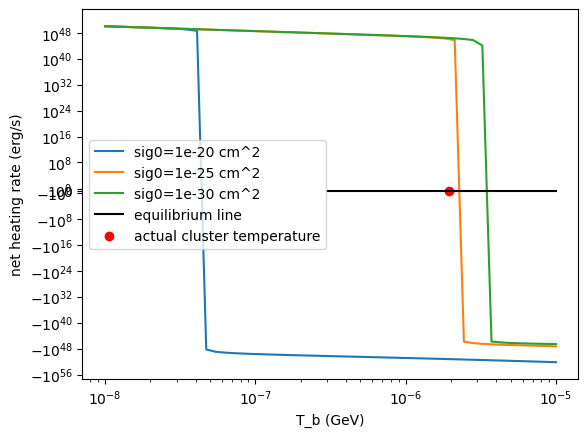

In [156]:
T_b = np.logspace(-8, -5)*u.GeV
#s0=1e-25*u.cm**2

#plt.loglog()
plt.yscale('symlog')
plt.xscale('log')

plt.xlabel('T_b (GeV)')
plt.ylabel('net heating rate (erg/s)')

plt.plot(T_b, equil(T_b, cls, 1e-20*u.cm**2), label='sig0=1e-20 cm^2')
plt.plot(T_b, equil(T_b, cls, 1e-25*u.cm**2), label='sig0=1e-25 cm^2')
plt.plot(T_b, equil(T_b, cls, 1e-30*u.cm**2), label='sig0=1e-30 cm^2') #any lower sig0 value is basically the same as this line
#plt.plot(T_b, equil(T_b, cls, 1e-40*u.cm**2), label='sig0=1e-40 cm^2')


plt.plot([3*1e-7,1e-5], [0,0], color='black', label='equilibrium line')
plt.scatter(cls.baryon_temp,0, color='red', label='actual cluster temperature')
plt.legend()

In [129]:
equil(1*u.GeV, cls, s0)

<Quantity -4.04867103e+54 GeV / s>

Text(0, 0.5, 'net heating rate (erg/s)')

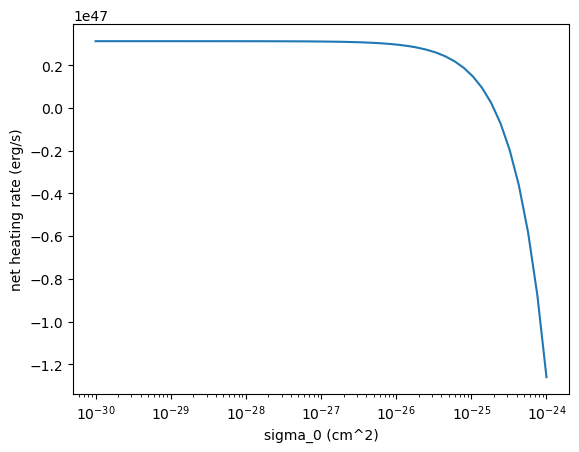

In [115]:
sig_0=np.logspace(-30, -24)*u.cm**2
plt.plot(sig_0,equil(cls.baryon_temp, cls, sig_0))
plt.xscale('log')

plt.xlabel('sigma_0 (cm^2)')
plt.ylabel('net heating rate (erg/s)')

In [102]:
equil(cls.baryon_temp, cls, 0*u.cm**2)

<Quantity 3.12811475e+46 GeV / s>